In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
import torchvision.datasets as tv_datasets
from torchvision import transforms as tv_transforms
from torchvision.utils import save_image, make_grid
from PIL import Image
from tqdm import tqdm
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics import JaccardIndex

import warnings
warnings.filterwarnings("ignore")

from experiment_utils import set_env, REPO_PATH, seed_everything
set_env()

from cgn_framework.mnists.models.classifier import CNN
from cgn_framework.mnists.train_cgn import save
from cgn_framework.mnists.dataloader import get_tensor_dataloaders, TENSOR_DATASETS

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Set environment

In [4]:
seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load model

In [5]:
# load model and its weights from a checkpoint
model = CNN()

# load checkpoint
weight_path = "mnists/experiments/classifier_colored_MNIST/weights/ckp_epoch_10.pth"
print("Loading model weights from checkpoint: {}".format(weight_path))
ckpt = torch.load(os.path.join(REPO_PATH, "cgn_framework", weight_path), map_location='cpu')
model.load_state_dict(ckpt)
model = model.eval()
model = model.to(device)

Loading model weights from checkpoint: mnists/experiments/classifier_colored_MNIST/weights/ckp_epoch_10.pth


### Load dataset

In [6]:
# load the test dataloader to evaluate GradCAM on
dataset = "colored_MNIST"
print("Loading dataset: {}".format(dataset))
dl_train, dl_test = get_tensor_dataloaders(dataset, 64)

Loading dataset: colored_MNIST


In [7]:
ds_test = dl_test.dataset

In [8]:
len(ds_test)

10000

In [9]:
# load original MNIST to obtain binary maps

T = tv_transforms.Compose([
    # tv_transforms.ToPILImage(),
    tv_transforms.Resize((32, 32), Image.NEAREST),
    tv_transforms.ToTensor(),
    # tv_transforms.Normalize(
    #     (0.5, 0.5, 0.5),
    #     (0.5, 0.5, 0.5),
    # ),
])

original = tv_datasets.MNIST(root="./mnists/data/MNIST/", download=True, train=False, transform=T)

In [10]:
original[0][0].shape, original[0][0].min(), original[0][0].max()

(torch.Size([1, 32, 32]), tensor(0.), tensor(1.))

### Compare colored MNIST with original MNIST (for indexing)

In [11]:
def denormalize(x, mean=[0.5, 0.5]):
    """Performs denormalization on image."""
    inv_normalize = transforms.Normalize(
        mean=[-1.0, -1.0, -1.0],
        std=[2.0, 2.0, 2.0]
    )
    return inv_normalize(x)

In [12]:
indices = np.random.choice(range(len(ds_test)), 16, replace=False)

ds_sample_images = [denormalize(ds_test[i][0]).permute((1, 2, 0)) for i in tqdm(indices, desc=dataset)]
ds_sample_labels = [ds_test[i][1] for i in indices]

og_sample_images = [original[i][0].permute((1, 2, 0)) for i in tqdm(indices, desc="Original")]
og_sample_labels = [original[i][1] for i in indices]

Original: 100%|██████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 4406.07it/s]


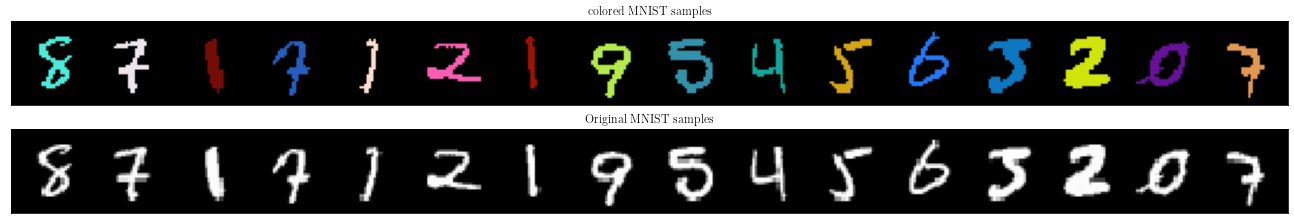

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(20, 3), constrained_layout=True)

grid_img = make_grid(torch.stack(ds_sample_images, dim=0).permute((0, 3, 1, 2)), nrow=len(indices))
ax[0].imshow(grid_img.permute((1, 2, 0)))
ax[0].set_title(f"{dataset.replace('_', ' ')} samples")
ax[0].set_xticks([])
ax[0].set_yticks([])

grid_img = make_grid(torch.stack(og_sample_images, dim=0).permute((0, 3, 1, 2)), nrow=len(indices))
ax[1].imshow(grid_img.permute((1, 2, 0)))
ax[1].set_title(f"Original MNIST samples")
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

### Test quantitative metric on a single sample

In [14]:
# define the target layer to be used
target_layer = model.model[8]
gradcam = GradCAM(model, target_layer)

# for metric computation
jaccard = JaccardIndex(num_classes=2)

In [15]:
sample_idx = 100

# get image
image = ds_test[sample_idx][0]

# get gradcam mask
gc_mask, _ = gradcam(image.unsqueeze(0))
heatmap, result = visualize_cam(gc_mask, image)
gc_mask = gc_mask.squeeze(0)

# get coresponding GT mask from original dataset
gt_mask = original[sample_idx][0]
gt_mask_binary = gt_mask > 0.5

In [16]:
gt_mask.shape, gc_mask.shape

(torch.Size([1, 32, 32]), torch.Size([1, 32, 32]))

In [17]:
iou = jaccard(gc_mask, gt_mask_binary)

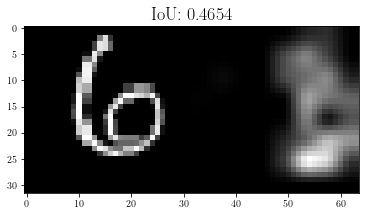

In [18]:
grid = make_grid([gt_mask, gc_mask], padding=0)

plt.title(f"IoU: {iou:.4f}", fontsize=18)
plt.imshow(grid.permute((1, 2, 0)))
plt.show()

### Looping over dataset

In [19]:
# define the target layer to be used
target_layer = model.model[8]
gradcam = GradCAM(model, target_layer)

# for metric computation
jaccard = JaccardIndex(num_classes=2)

In [20]:
iterator = tqdm(range(len(ds_test)), colour="red", bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', desc="Computing GradCAM")
iou_values = []
labels = []

show = False

for i in iterator:

    # get image
    image, label = ds_test[i]

    # get gradcam mask
    gc_mask, _ = gradcam(image.unsqueeze(0))
    heatmap, result = visualize_cam(gc_mask, image)
    gc_mask = gc_mask.squeeze(0)

    # get coresponding GT mask from original dataset
    gt_mask = original[i][0]
    gt_mask_binary = gt_mask > 0.5

    iou = jaccard(gc_mask, gt_mask_binary)
    iou_values.append(iou)
    labels.append(label)
    
    if show:
        grid = make_grid([gt_mask, gc_mask], padding=0)
        plt.title(f"IoU: {iou:.4f}", fontsize=18)
        plt.imshow(grid.permute((1, 2, 0)))
        plt.show()

Computing GradCAM: 100%|██████████| 10000/10000 [07:11<00:00, 23.17it/s]                                                               


In [28]:
df = pd.DataFrame(None, columns=["iou", "label"])
df["iou"] = iou_values
df["label"] = torch.stack(labels).numpy()

In [32]:
dict(df.groupby("label")["iou"].mean()), df["iou"].mean()

({0: 0.43806566510881695,
  1: 0.42117731707736783,
  2: 0.4524344806523286,
  3: 0.44586656022780013,
  4: 0.4213300654455989,
  5: 0.43183012821214617,
  6: 0.4619055889344663,
  7: 0.43468312066816633,
  8: 0.42896266052120763,
  9: 0.43286967584706393},
 0.436745068359375)